In [2]:
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import copy 

from models import *
from utils import *

# Importing CIFAR-10 

In [3]:
MEANS = (0.5, 0.5, 0.5)
STDS = (0.5, 0.5, 0.5)
BATCH_SIZE = 4
IMG_SIZE = (128, 128)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE),
    transforms.Normalize(MEANS, STDS)
    ])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2
    )

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=2
    )

classes = (
    'plane', 'car', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
    )

Files already downloaded and verified
Files already downloaded and verified


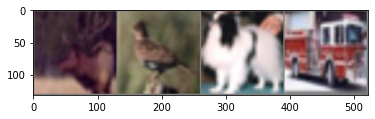

 deer  bird   dog truck


In [4]:
def imshow(img):
    # unnormalize
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

In [5]:
print(images.shape, labels.shape)

torch.Size([4, 3, 128, 128]) torch.Size([4])


# D-CONV and S-CONV

**NOTE 1** - with proper padding, they're all good

**NOTE 2** - passed the sanity check from tables 3 and 4


In [6]:
ALPHA = 1
NUM_CLASSES = 10
IN_CHANNELS = 3

d_conv = DConv(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES)
s_conv = SConv(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES)


In [7]:
out_d = d_conv(images)
out_s = s_conv(images)

print(out_d.shape)
print(out_s.shape)


torch.Size([4, 10])
torch.Size([4, 10])


## Padding discussion


In [8]:
print('Without padding - NO MATCH \n')
print(get_true_parameters_count('D-CONV', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(d_conv), '\n')

print(get_true_parameters_count('S-CONV', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(s_conv), '\n')

print('Padding: D-1, S-4 - MATCH \n')
d_conv = DConv(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES, padding=1)
s_conv = SConv(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES, padding=4)

print(get_true_parameters_count('D-CONV', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(d_conv), '\n')

print(get_true_parameters_count('S-CONV', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(s_conv), '\n')


Without padding - NO MATCH 

68507
28553 

98787
86883 

Padding: D-1, S-4 - MATCH 

68507
68489 

98787
98787 



# D-FC and S-FC

**NOTE 1** - Should be correct

**NOTE 2** - passed the sanity check from tables 3 and 4


In [9]:
s_fc = SFC(IN_CHANNELS, ALPHA, IMG_SIZE, NUM_CLASSES)
d_fc = DFC(IN_CHANNELS, ALPHA, IMG_SIZE, NUM_CLASSES)

out_fc_d = d_fc(images)
out_fc_s = s_fc(images)

print(out_fc_d.shape)
print(out_fc_s.shape)

Without padding - NO MATCH 

68507
68489 

98787
98787 

Padding: D-1, S-4 - MATCH 

68507
68489 

98787
98787 



# D-LOCAL and S-LOCAL

**NOTE** - Locally connected networks are not implemented in pytorch, 
so we have to implement them ourselves. Again, check if this makes sense, 
I found this implementation by ptrblck on torch hub, to me it makes sense, 
**but** the parameters don't match for the D-LOCAL case.

However, I don't agree with Tables 3 and 4 about the number of parameters for 
D-LOCAL! I think there's a mistake there.

In [10]:
s_local = SLocal(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES, padding=4)
d_local = DLocal(IN_CHANNELS, ALPHA, IMG_SIZE, num_classes=NUM_CLASSES, padding=1)

print(s_local(images).shape)
print(d_local(images).shape)

torch.Size([4, 10])
torch.Size([4, 10])


## Parameter count


In [11]:
print(get_true_parameters_count('S-LOCAL', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(s_local), '\n')

print(get_true_parameters_count('D-LOCAL', ALPHA, IMG_SIZE, NUM_CLASSES))
print(count_parameters(d_local))

1093872.0
1093872 

656000
1245824


## Recreating Table 3 and Table 4, row 2


In [12]:
s_square = IMG_SIZE[0]**2

cnt = count_parameters(d_local.local_layers[0].layers)
print(f'9 x {cnt // 9 // ALPHA // s_square} x {IMG_SIZE[0]}^2 x {ALPHA}')

for i in range(1, len(d_local.local_layers)):
    cnt = count_parameters(d_local.local_layers[i].layers)
    # print(d_local.local_layers[i].layers[0].weight.shape)
    # print(cnt)
    print(f'9 x {IMG_SIZE[0]}^2 x {ALPHA}^2 / {9 * s_square // cnt // ALPHA**2}')

cnt = count_parameters(d_local.fc_layers[0])
print(f'4 x {int((cnt // 4 // ALPHA**2) ** 0.5)}^2 x {ALPHA**2}')

cnt = count_parameters(d_local.fc_layers[1])
print(f'{cnt // ALPHA // NUM_CLASSES} x {NUM_CLASSES} x {ALPHA}')

9 x 3 x 128^2 x 1
9 x 128^2 x 1^2 / 2
9 x 128^2 x 1^2 / 1
9 x 128^2 x 1^2 / 2
9 x 128^2 x 1^2 / 1
9 x 128^2 x 1^2 / 2
9 x 128^2 x 1^2 / 1
9 x 128^2 x 1^2 / 2
4 x 128^2 x 1
64 x 10 x 1


## IMPLEMENTATION OF 3-FC - IN PROGRESS !!!

**NOTE** - I got stuck with this one because there's very little info about it

Please check this one in the paper thoroughly and we'll discuss it

# Implementing $\beta$-LASSO

In [57]:
from torch.optim.optimizer import Optimizer, required
import copy

class BetaLASSO(Optimizer):
    def __init__(self, params, beta, lr, lambda_):
        defaults = dict(lr=lr, beta=beta, lambda_=lambda_)
        super(BetaLASSO, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(BetaLASSO, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr, beta, lambda_ = group['lr'], group['beta'], group['lambda_']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                p.data.add_(-lr, d_p + lambda_ * torch.sign(p.data))
                threshold_mask = torch.where(
                    (p.data <= -beta*lambda_) | (p.data >= beta*lambda_),
                    p.data.type(torch.DoubleTensor), 0.
                    )

                p.data.mul_(threshold_mask)

        return loss

In [58]:
from models import *

model = SFC(3, 1, IMG_SIZE)


In [59]:
optim = BetaLASSO(model.parameters(), 10, 0.1, 0.1)

In [60]:
preds = model(images)


In [61]:
crit = torch.nn.BCELoss()
loss = crit(torch.nn.functional.one_hot(labels).to(torch.float32), preds)

loss.backward()

In [62]:
p = optim.step()

In [50]:
torch.where(
    (p <= -2) | (p >= 2), p.type(torch.DoubleTensor), 0.
    )

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [46]:
(p <= -2) | (p >= 2)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])